In [22]:
import os
import pandas as pd
import datetime
import xlsxwriter
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns

In [37]:
#匯入資料
os.chdir('D:\\01_開發資料\\流程管理\\')
df = pd.read_excel('MoldData.xlsx',sheet_name='工作表1') #起訖時間
df1 = pd.read_excel('MoldData.xlsx',sheet_name='工作表2') #中斷時間

In [38]:
#
nan_value = float('NaN')
df.replace('', nan_value, inplace=True)
df1.replace('', nan_value, inplace=True)
df.dropna(subset=['結束時間'], inplace=True)
col = ['開始時間','結束時間']
for i in col:
    df[i] = pd.to_datetime(df[i], format='%Y-%m-%d %H:%M:%S')

col1 = ['暫停時間1','繼續時間1','暫停時間2','繼續時間2']
for j in col1:
    df1[j] = pd.to_datetime(df1[j], format='%Y-%m-%d %H:%M:%S')

In [39]:
#添加欄位
df['中斷時間'] = pd.DataFrame(df1['繼續時間1']-df1['暫停時間1']).fillna(pd.Timedelta(seconds=0))+ pd.DataFrame(df1['繼續時間2']-df1['暫停時間2']).fillna(pd.Timedelta(seconds=0))
df = df.assign(工作小時=lambda x: x.結束時間-x.開始時間-x.中斷時間)
result = df.set_index('模具編號')

In [45]:
#資料處理
result1 = pd.pivot_table(result.drop(columns=['員工姓名']),index='模具編號',values='工作小時',columns='機台編號')
result1.columns.name = None
result1.index.name = None
result1 = result1/pd.Timedelta(hours=1)
result1 = result1.round(2)
result2 = result1.fillna(0)
result3 = result1.fillna('')
result4 = result2.assign(CNC=lambda x: x.CNC01+x.CNC02+x.CNC03)
result4 = result4.assign(EDM=lambda x: x.EDM01+x.EDM02+x.EDM05)
result3.loc['Section_time'] = result4.apply(lambda x: x.sum())
result4.drop(columns=['CNC01', 'CNC02', 'CNC03', 'EDM01', 'EDM02', 'EDM05'], inplace=True)
result3['Mold_time'] = result4.apply(lambda x: x.sum(), axis=1)
result5 = pd.DataFrame({'CAD': result4['CAD01'],'CAM': result4['CAM02'],'CNC': result4['CNC'],'EDM': result4['EDM'],'FILTER': result4['FILTER']})
result5.loc['Section_time'] = result5.apply(lambda x: x.sum())
result6 = result3.drop(columns=['CAD01','CAM02','FILTER','Mold_time'])
section = result6.columns.values.tolist()
for list in section:
    filter = result6[list] != ''
    result6 = result6[filter]
result6 = result6.T.reset_index()
result6.columns = ['Machine', 'Time(hr)']

In [11]:
result3

,CAD01,CAM02,CNC01,CNC02,CNC03,EDM01,EDM02,EDM05,FILTER,Mold_time
Support,,,7.46,,7.86,,,,,15.32
Test,,,2.17,,1.83,,,,,4.00
XBM0179,,,,,,,,,79.78,79.78
XCL0417-D,,,,,8.3,,,265.4,0.9,274.60
XSA0617,4.53,,,,,,,,,4.53
XSC1423-D,,,,,,,,,1.46,1.46
XSC1593,,,,,,,,,1.85,1.85
XSC1608,,,,,,,,,0.9,0.90
XSC1625-D,,,,,,,,,1.77,1.77
XSC1631,,,,,,,,,1.71,1.71


In [12]:
#創建資料夾
date = datetime.date.today().strftime("%Y-%m-%d")
os.chdir('result')
file = pathlib.Path(date)
if file.exists():
    os.chdir(date)
else:
    os.mkdir(date)
    os.chdir(date)

In [13]:
#匯出excel報表
writer = pd.ExcelWriter(date+' mold_analysis.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
df.to_excel(writer, sheet_name='總表')
result3.to_excel(writer, sheet_name='分析')


# Close the Pandas Excel writer and output the Excel file.
writer.save()

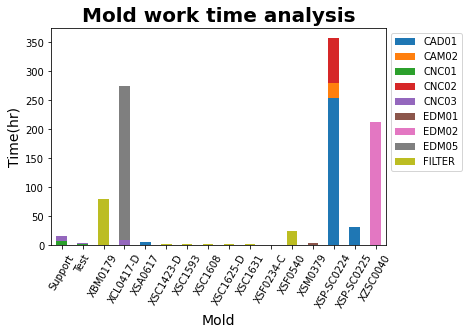

In [14]:
#繪製模具時數長條圖
mold = result2.index.values.tolist()
x = np.arange(len(mold))
result2.apply(pd.to_numeric).plot(kind='bar', stacked=True)
plt.xticks(x, mold, rotation=60)
plt.xlabel('Mold', fontsize='14')
plt.ylabel('Time(hr)', fontsize='14')
plt.title('Mold work time analysis', fontweight='bold', fontsize='20')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
#plt.show()
plt.savefig('Mold_Analysis.png', bbox_inches='tight')

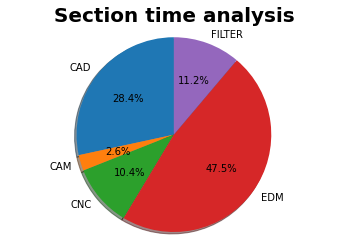

In [15]:
#繪製Pie圖,plotted counter-clockwise:
labels = result5.columns.values
sizes = result5.iloc[-1].dropna().tolist()
explode = len(labels)*[0]  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Section time analysis', fontweight='bold', fontsize='20')
#plt.legend(bbox_to_anchor=(1,1), loc='upper left')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#plt.show()
plt.savefig('Section_Analysis.png', bbox_inches='tight')

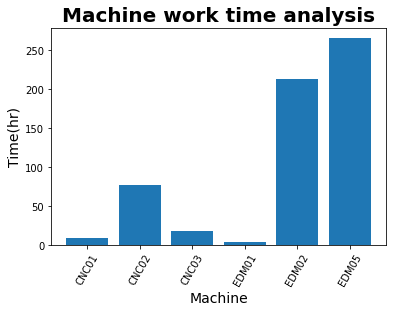

In [23]:
#繪製機器加工時數長條圖
section = result6.columns.values.tolist()
hr = result6.iloc[-1].tolist()
x = np.arange(len(section))
plt.bar(x, hr)
plt.xticks(x, section, rotation=60)
plt.xlabel('Machine', fontsize='14')
plt.ylabel('Time(hr)', fontsize='14')
plt.title('Machine work time analysis', fontweight='bold', fontsize='20')
#plt.show()
plt.savefig('Machine_Analysis.png', bbox_inches='tight')

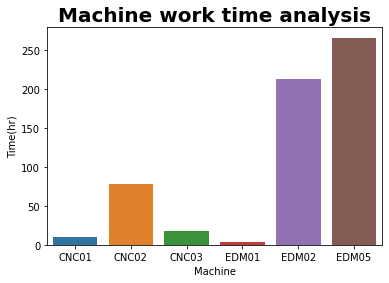

In [62]:
#繪製機器加工時數長條圖
ax = sns.barplot(x='Machine', y='Time(hr)', data=result6)
ax.set_title('Machine work time analysis', fontweight='bold', fontsize='20')
sfig = ax.get_figure()
sfig.savefig('Machine_Analysis.png',  orientation="landscape")

In [71]:
def mold_analysis():
    os.chdir('D:\\01_開發資料\\流程管理\\')
    df = pd.read_excel('MoldData.xlsx',sheet_name='工作表1')
    df1 = pd.read_excel('MoldData.xlsx',sheet_name='工作表2')
    nan_value = float('NaN')
    df.replace('', nan_value, inplace=True)
    df1.replace('', nan_value, inplace=True)
    df.dropna(subset=['結束時間'], inplace=True)
    col = ['開始時間','結束時間']
    for list in col:
        df[list] = pd.to_datetime(df[list], format='%Y-%m-%d %H:%M:%S')

    col1 = ['暫停時間1','繼續時間1','暫停時間2','繼續時間2']
    for list in col1:
        df1[list] = pd.to_datetime(df1[list], format='%Y-%m-%d %H:%M:%S')

    df['中斷時間'] = pd.DataFrame(df1['繼續時間1']-df1['暫停時間1']).fillna(pd.Timedelta(seconds=0))+ pd.DataFrame(df1['繼續時間2']-df1['暫停時間2']).fillna(pd.Timedelta(seconds=0))
    df = df.assign(工作小時=lambda x: x.結束時間-x.開始時間-x.中斷時間)
    result = df.set_index('模具編號')
    result1 = pd.pivot_table(result.drop(columns=['員工姓名']),index='模具編號',values='工作小時',columns='機台編號')
    result1.columns.name = None
    result1.index.name = None
    result1 = result1/pd.Timedelta(hours=1)
    result1 = result1.round(2)
    result2 = result1.fillna(0)
    result3 = result1.fillna('')
    result4 = result2.assign(CNC=lambda x: x.CNC01+x.CNC02+x.CNC03)
    result4 = result4.assign(EDM=lambda x: x.EDM01+x.EDM02+x.EDM05)
    result3.loc['Section_time'] = result4.apply(lambda x: x.sum())
    result4.drop(columns=['CNC01', 'CNC02', 'CNC03', 'EDM01', 'EDM02', 'EDM05'], inplace=True)
    result3['Mold_time'] = result4.apply(lambda x: x.sum(), axis=1)
    result5 = pd.DataFrame({'CAD': result4['CAD01'],'CAM': result4['CAM02'],'CNC': result4['CNC'],'EDM': result4['EDM'],'FILTER': result4['FILTER']})
    result5.loc['Section_time'] = result5.apply(lambda x: x.sum())
    result6 = result3.drop(columns=['CAD01','CAM02','FILTER','Mold_time'])
    section = result6.columns.values.tolist()
    for list in section:
        filter = result6[list] != ''
        result6 = result6[filter]
    result6 = result6.T.reset_index()
    result6.columns = ['Machine', 'Time(hr)']

    #創建資料夾
    date = datetime.date.today().strftime("%Y-%m-%d")
    os.chdir('result')
    file = pathlib.Path(date)
    if file.exists():
        os.chdir(date)
    else:
        os.mkdir(date)
        os.chdir(date)

    #匯出excel報表
    writer = pd.ExcelWriter(date+' mold_analysis.xlsx', engine='xlsxwriter')
    df.to_excel(writer, sheet_name='總表')
    result3.to_excel(writer, sheet_name='分析')
    writer.save()

    #繪製模具時數長條圖
    mold = result2.index.values.tolist()
    x = np.arange(len(mold))
    result2.apply(pd.to_numeric).plot(kind='bar', stacked=True)
    plt.xticks(x, mold, rotation=60)
    plt.xlabel('Mold', fontsize='14')
    plt.ylabel('Time(hr)', fontsize='14')
    plt.title('Mold work time analysis', fontweight='bold', fontsize='20')
    plt.legend(bbox_to_anchor=(1,1), loc='upper left')
    #plt.show()
    plt.savefig('Mold_Analysis.png', bbox_inches='tight')
    plt.pause(0.1)

    #繪製Pie圖
    labels = result5.columns.values
    sizes = result5.iloc[-1].dropna().tolist()
    explode = len(labels)*[0]  
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.title('Section time analysis', fontweight='bold', fontsize='20')
    ax1.axis('equal')  

    #plt.show()
    plt.savefig('Section_Analysis.png', bbox_inches='tight')
    plt.pause(0.1)

    #繪製機器加工長條圖
    ax = sns.barplot(x='Machine', y='Time(hr)', data=result6)
    ax.set_title('Machine work time analysis', fontweight='bold', fontsize='20')
    sfig = ax.get_figure()
    sfig.savefig('Machine_Analysis.png',  orientation="landscape")

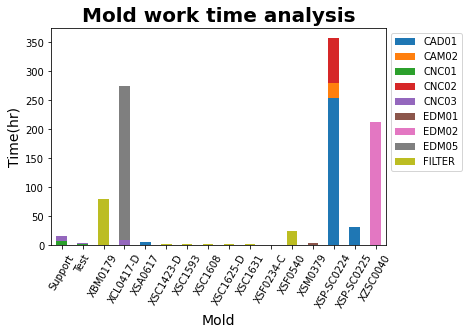

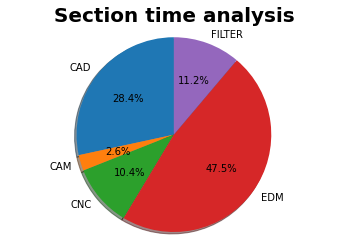

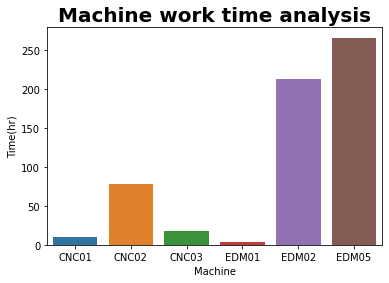

In [70]:
mold_analysis()